In [1]:
import numpy as np
import scipy
from matplotlib import pyplot as plt
import time
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ExpSineSquared
from sklearn.gaussian_process import GaussianProcessRegressor

import numpy as np
from sklearn.gaussian_process.kernels import StationaryKernelMixin, NormalizedKernelMixin, Kernel
from sklearn.gaussian_process.kernels import Hyperparameter
from scipy.spatial.distance import pdist, cdist
from scipy.spatial.distance import squareform

In [2]:
class Cosine(StationaryKernelMixin, NormalizedKernelMixin, Kernel):
    """Cosine kernel.

    Parameters
    ----------
    period : float or ndarray of shape (n_features,), default=1.0
        The period of the kernel. If a float, an isotropic kernel is
        used. If an array, an anisotropic kernel is used where each dimension
        of l defines the length-scale of the respective feature dimension.

    period_bounds : pair of floats >= 0 or "fixed", default=(1e-5, 1e5)
        The lower and upper bound on 'period'.
        If set to "fixed", 'period' cannot be changed during
        hyperparameter tuning.
    """

    def __init__(self, period=1.0, period_bounds=(1e-5, 1e5)):
        self.period = period
        self.period_bounds = period_bounds

    @property
    def anisotropic(self):
        return np.iterable(self.period) and len(self.period) > 1

    @property
    def hyperparameter_period(self):
        if self.anisotropic:
            return Hyperparameter(
                "period",
                "numeric",
                self.period_bounds,
                len(self.period),
            )
        return Hyperparameter("period", "numeric", self.period_bounds)

    def __call__(self, X, Y=None, eval_gradient=False):
        """Return the kernel k(X, Y) and optionally its gradient.

        Parameters
        ----------
        X : ndarray of shape (n_samples_X, n_features)
            Left argument of the returned kernel k(X, Y)

        Y : ndarray of shape (n_samples_Y, n_features), default=None
            Right argument of the returned kernel k(X, Y). If None, k(X, X)
            if evaluated instead.

        eval_gradient : bool, default=False
            Determines whether the gradient with respect to the log of
            the kernel hyperparameter is computed.
            Only supported when Y is None.

        Returns
        -------
        K : ndarray of shape (n_samples_X, n_samples_Y)
            Kernel k(X, Y)

        K_gradient : ndarray of shape (n_samples_X, n_samples_X, n_dims), \
                optional
            The gradient of the kernel k(X, X) with respect to the log of the
            hyperparameter of the kernel. Only returned when `eval_gradient`
            is True.
        """
        X = np.atleast_2d(X)
        period = self.period
        if Y is None:
            dists = pdist(X / period, metric="euclidean")
            K = np.cos(2 * np.pi * dists)
            # convert from upper-triangular matrix to square matrix
            K = squareform(K)
            np.fill_diagonal(K, 1)
        else:
            if eval_gradient:
                raise ValueError("Gradient can only be evaluated when Y is None.")
            dists = cdist(X / period, Y / period, metric="euclidean")
            K = np.cos(2 * np.pi * dists)

        if eval_gradient:
            if self.hyperparameter_period.fixed:
                # Hyperparameter l kept fixed
                return K, np.empty((X.shape[0], X.shape[0], 0))
            elif not self.anisotropic or period.shape[0] == 1:
                # K_gradient = (K * squareform(dists))[:, :, np.newaxis]
                K_gradient = squareform(2 * np.pi * np.sin(2 * np.pi * dists) * dists)[:, :, np.newaxis]
                return K, K_gradient
            elif self.anisotropic:
                # We need to recompute the pairwise dimension-wise distances
                K_gradient = (X[:, np.newaxis, :] - X[np.newaxis, :, :]) / (
                    period
                )
                K_gradient *= 2 * np.pi * np.sin(2 * np.pi * K_gradient[..., np.newaxis])
                return K, K_gradient
        else:
            return K

    def __repr__(self):
        if self.anisotropic:
            return "{0}(period=[{1}])".format(
                self.__class__.__name__,
                ", ".join(map("{0:.3g}".format, self.period)),
            )
        else:  # isotropic
            return "{0}(period={1:.3g})".format(
                self.__class__.__name__, np.ravel(self.period)[0]
            )

In [3]:
def construct_cosine_kernel(params):
    kernel = params[0] * Cosine(period=params[1], period_bounds = (params[1] / 2, 2 * params[1]))
    return kernel

def simulate(n, true_params, initial_params, eps, num_restarts = 1):
    x = np.linspace(start = 0, stop = 1, num = n).reshape(-1, 1)
    shift = np.random.uniform(-1 / (4 * n), 1 / (4 * n), size=n).reshape(-1, 1)
    x = x + shift
    true_kernel = construct_cosine_kernel(true_params) + WhiteKernel(noise_level=eps)
    true_gp = GaussianProcessRegressor(kernel = true_kernel, alpha=0)
    y = np.squeeze(true_gp.sample_y(x, random_state=None))
    #plt.plot(x, y)
    kernel = construct_cosine_kernel(initial_params)
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=num_restarts, alpha=eps)
    gp.fit(x, y)
    
    gp_params = gp.kernel_.get_params()
    numerical_params = [value for key, value in gp_params.items() if isinstance(value, (int, float, np.float64))]
    return numerical_params

n = 500
true_params = [1, 1 / 4]
initial_params = [1, 1 / 4]
eps = 1e-9
simulate(n, true_params, initial_params, eps, 1)
    

/nas/longleaf/rhel8/apps/anaconda/2021.11.ood/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


[2.781976270061316, 0.25000004264314263]

In [4]:
def get_param_estimates(sample_sizes, true_params, initial_params, eps, num_restarts, num_replicates):
    # Collect estimates
    estimates = []
    for n in sample_sizes:
        estimates.append([simulate(n, true_params, initial_params, eps, num_restarts) for _ in range(num_replicates)])
    
    param_estimates = [[[est[i] for est in sample] for sample in estimates] for i in range(len(true_params))]
    flattened_estimates = np.array(param_estimates).reshape(len(true_params), -1)  # Flatten the nested list
    np.savetxt('./results/cosine-simulation.txt', flattened_estimates)
    return param_estimates
    
def generate_boxplots(param_estimates, true_params, sample_sizes, param_names):
    # Create boxplots
    fig, axs = plt.subplots(1, len(true_params), figsize=(12, 6))
    for i, param_estimate in enumerate(param_estimates):
        axs[i].boxplot(param_estimate, labels=sample_sizes, vert=True)
        axs[i].axhline(y=true_params[i], color='r', alpha=0.5, linestyle='--')
        axs[i].set_xticks(range(1, len(sample_sizes) + 1))
        axs[i].set_xlabel('Sample Size', fontsize=15)
        axs[i].set_title(f'{param_names[i]}', fontsize=20)

    plt.tight_layout()
    plt.savefig('./boxplots/cosine-simulation.png')
    plt.show()

# Timing execution
start_time = time.time()

# Parameters
num_replicates = 100
true_params = [1, 1 / 4]  # Example true parameters
initial_params = [1, 1 / 4]
eps = 0.1
num_restarts = 0
sample_sizes = [50, 100, 200, 500]  # Example sample sizes

# Generate plots
np.random.seed(2024)
param_estimates = get_param_estimates(sample_sizes, true_params, initial_params, eps, num_restarts, num_replicates)

end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")


/nas/longleaf/rhel8/apps/anaconda/2021.11.ood/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Execution time: 284.58104944229126 seconds


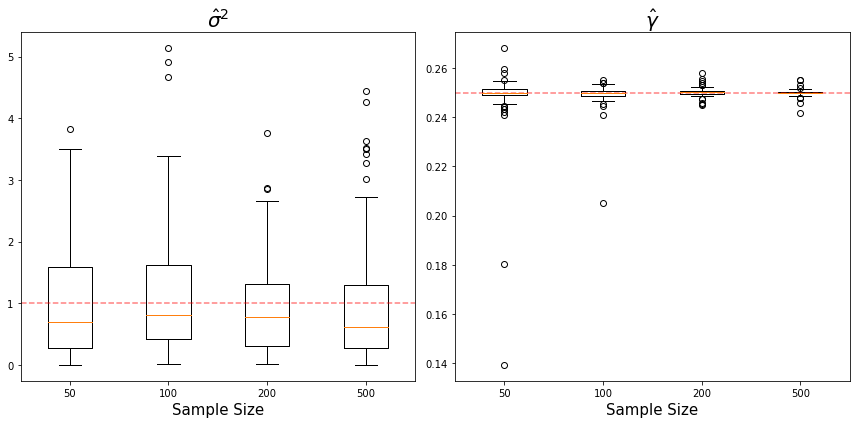

In [5]:
flattened_estimates = np.loadtxt('./results/cosine-simulation.txt')
param_estimates = flattened_estimates.reshape(len(true_params), len(sample_sizes), num_replicates).tolist()
param_names = [r'$\hat{\sigma}^2$', r'$\hat{\gamma}$']
generate_boxplots(param_estimates, true_params, sample_sizes, param_names)

In [6]:
def check(n, params):
        kernel = construct_cosine_kernel(params)
        print(kernel)
        x = np.linspace(start = 0, stop = 1, num = n).reshape(-1, 1)
        shift = np.random.uniform(0, 1, size=n).reshape(-1, 1)
        K = kernel(x)
        print(K)
        eigvals = np.sort(np.linalg.eigvalsh(K))
        eigvecs = np.linalg.eigh(K).eigenvectors
        print(np.linalg.cond(K))
        print(eigvals)
    
n = 5
params = [1, 2]
check(n, params)

1**2 * Cosine(period=2)
[[ 1.00000000e+00  7.07106781e-01  6.12323400e-17 -7.07106781e-01
  -1.00000000e+00]
 [ 7.07106781e-01  1.00000000e+00  7.07106781e-01  6.12323400e-17
  -7.07106781e-01]
 [ 6.12323400e-17  7.07106781e-01  1.00000000e+00  7.07106781e-01
   6.12323400e-17]
 [-7.07106781e-01  6.12323400e-17  7.07106781e-01  1.00000000e+00
   7.07106781e-01]
 [-1.00000000e+00 -7.07106781e-01  6.12323400e-17  7.07106781e-01
   1.00000000e+00]]


AttributeError: 'tuple' object has no attribute 'eigenvectors'